In [248]:


import psycopg2
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)
import matplotlib
import warnings
import yellowbrick as yb
matplotlib.style.use('ggplot')

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from yellowbrick.classifier import ClassificationReport

warnings.simplefilter(action='ignore', category=FutureWarning)

In [249]:
conn = psycopg2.connect( 
                        host = 'project.cgxhdwn5zb5t.us-east-1.rds.amazonaws.com',
                        port = 5432, 
                        user = 'postgres',
                        password = 'Admin123',
                        database = 'postgres')
cursor = conn.cursor()

In [250]:
DEC2FLOAT = psycopg2.extensions.new_type(
    psycopg2.extensions.DECIMAL.values,
    'DEC2FLOAT',
    lambda value, curs: float(value) if value is not None else None)
psycopg2.extensions.register_type(DEC2FLOAT)

In [251]:
cursor.execute('Select * from "ahshouseholdclass2"')
rows = cursor.fetchall()
col_names = []
for elt in cursor.description:
    col_names.append(elt[0])

df = pd.DataFrame(data=rows, columns=col_names )

In [252]:
#df = pd.read_csv('AHS Household Class.csv')

In [253]:
df.columns

Index(['index', 'CONTROL', 'YEAR', 'RATINGHS_BIN', 'BEDROOMS', 'STORIES',
       'PERPOVLVL', 'HHADLTKIDS', 'HINCP', 'UNITSIZE', 'NUMVETS', 'LOTSIZE',
       'UFINROOMS', 'HHAGE', 'PARTNER', 'OTHERAMT', 'KITCHENS', 'NUMSECFAM',
       'OILAMT', 'DINING', 'FINCP', 'NUMELDERS', 'WATERAMT', 'GASAMT',
       'TOTROOMS', 'HHYNGKIDS', 'NUMSUBFAM', 'BATHROOMS', 'NUMYNGKIDS',
       'TRASHAMT', 'NUMOLDKIDS', 'NUMNONREL', 'NUMPEOPLE', 'HHMOVE', 'UTILAMT',
       'ELECAMT', 'NUMADULTS', 'MULTIGEN', 'LAUNDY', 'HHOLDKIDS', 'FINROOMS',
       'LN_HINCP', 'LN_FINCP', 'HINCP_BIN', 'FINCP_BIN', 'NUMCARE', 'NUMWALK',
       'HHRACE', 'OMB13CBSA', 'HSHLDTYPE', 'MVG3COST', 'MVG2COST', 'MILHH',
       'HHMAR', 'HHNATVTY', 'COOKFUEL', 'NUMMEMRY', 'NUMERRND', 'NUMSEE',
       'BLD', 'NUMHEAR', 'MVG1COST', 'DIVISION', 'FIREPLACE', 'CONDO',
       'OWNLOT', 'FRIDGE', 'FIRSTHOME', 'HHCARE', 'NOSTEP', 'WASHER', 'HHSEE',
       'KITCHSINK', 'HHERRND', 'WINBARS', 'HHWALK', 'HHHEAR', 'HHSEX',
       'HHMEMRY', 'GA

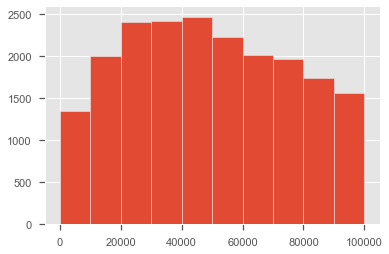

In [254]:
df['HINCP'].hist()

In [255]:
df['RATINGHS_BIN'].value_counts()

extremely satisfied    7021
satisfied              5284
not satisfied          4887
very satisfied         2916
Name: RATINGHS_BIN, dtype: int64

In [ ]:
sns.distplot(df['RATINGHS_BIN'], bins=4, kde=False, rug=True);

### Class Imbalanced

In [280]:
X = df[['HHAGE', 'HINCP', 'BATHROOMS', 'UTILAMT','PERPOVLVL',  'ELECAMT', 'GASAMT', 'TRASHAMT', 'WATERAMT', 'OMB13CBSA','UNITSIZE','NUMPEOPLE','STORIES', 'HHNATVTY']]

y = df['RATINGHS_BIN']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c39ae4358>,
      dtype=object)

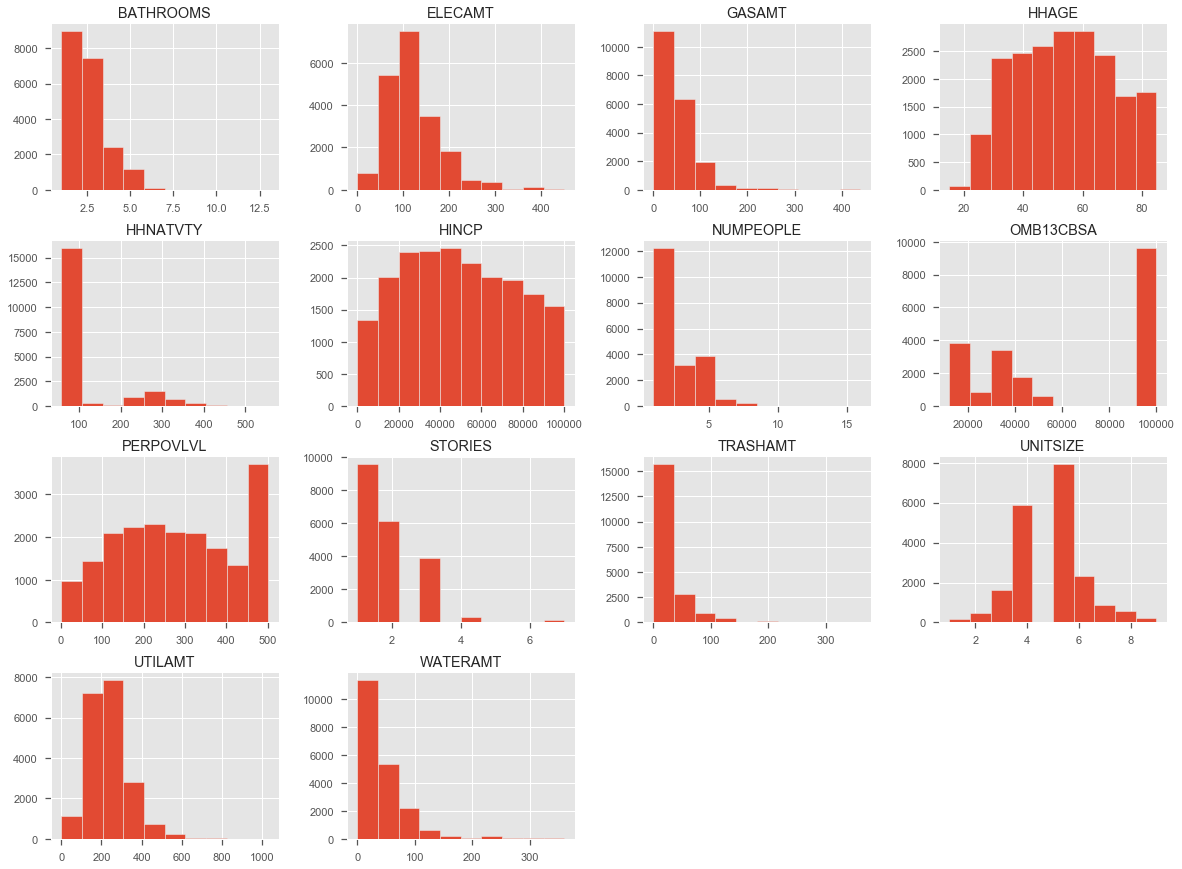

In [281]:
X.hist(figsize=(20,15))

In [282]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 33)

/Users/sabashaikh/anaconda2/envs/py36/lib/python3.6/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


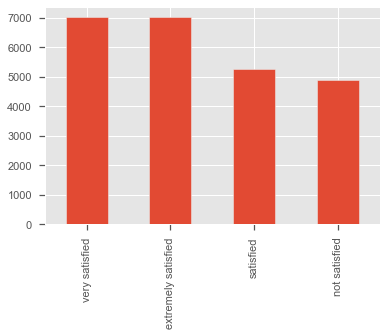

In [283]:
X_sm, y_sm = sm.fit_sample(X, y.ravel())
pd.Series(y_sm).value_counts().plot.bar()

In [284]:
#pd.Series(y_sm).value_counts().plot.bar()

/Users/sabashaikh/anaconda2/envs/py36/lib/python3.6/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


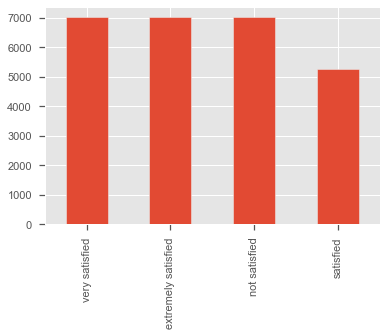

In [285]:
X_sm, y_sm = sm.fit_sample(X_sm, y_sm.ravel())
pd.Series(y_sm).value_counts().plot.bar()

/Users/sabashaikh/anaconda2/envs/py36/lib/python3.6/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


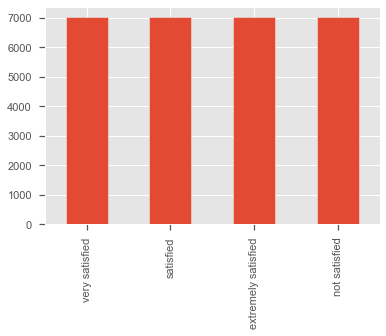

In [286]:
X_sm, y_sm = sm.fit_sample(X_sm, y_sm.ravel())
pd.Series(y_sm).value_counts().plot.bar()

Precision: It is implied as the measure of the correctly identified positive cases from all the predicted positive cases. Thus, it is useful when the costs of False Positives is high.

Recall: It is the measure of the correctly identified positive cases from all the actual positive cases. It is important when the cost of False Negatives is high.

Accuracy: One of the more obvious metrics, it is the measure of all the correctly identified cases. It is most used when all the classes are equally important.


In [287]:
# Create the train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_sm, y_sm, test_size=0.2)

In [290]:
from sklearn import metrics
def score_model(X, y, estimator, **kwargs):
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
         ('one_hot_encoder', OneHotEncoder()), 
         ('estimator', estimator)
    ])


    model.fit(X_train, y_train.ravel(), **kwargs)  
    
    expected  = y_test
    predicted = model.predict(X_test)
    
    print("{}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted, average='micro')))
  #  print("{} Accuracy Score: {}".format(estimator.__class__.__name__, metrics.accuracy_score(expected, predicted)))

In [292]:
models = [
    SVC(), NuSVC(), LinearSVC(), 
    SGDClassifier(), KNeighborsClassifier(), 
    LogisticRegression(), 
    ExtraTreesClassifier(n_estimators=100, max_features='log2', n_jobs=2, random_state=42),
    RandomForestClassifier(n_estimators=100, random_state=42),
    DecisionTreeClassifier(),
    AdaBoostClassifier(learning_rate=0.7,n_estimators=200),
    GradientBoostingClassifier(n_estimators=100, learning_rate=.5,max_depth=4)
    #learning_rate=.5,max_depth=4, min_samples_leaf=75
]

for model in models:
    score_model(X_train, y_train.ravel(), model)

SVC: 0.24550471782090083
NuSVC: 0.3583763574862026
LinearSVC: 0.3685241231974363
SGDClassifier: 0.38579312800427273
KNeighborsClassifier: 0.33558839238027416
LogisticRegression: 0.3861491899590529
ExtraTreesClassifier: 0.41053943386149194
RandomForestClassifier: 0.4060886594267403
DecisionTreeClassifier: 0.34342175538543707
AdaBoostClassifier: 0.3957628627381165
GradientBoostingClassifier: 0.3941605839416059


In [300]:
models = [
    ExtraTreesClassifier(),
    RandomForestClassifier()
  
]

for model in models:
    score_model(X_train, y_train.ravel(), model)

ExtraTreesClassifier: 0.3633612248531244
RandomForestClassifier: 0.3631831938757344


## Classification Report

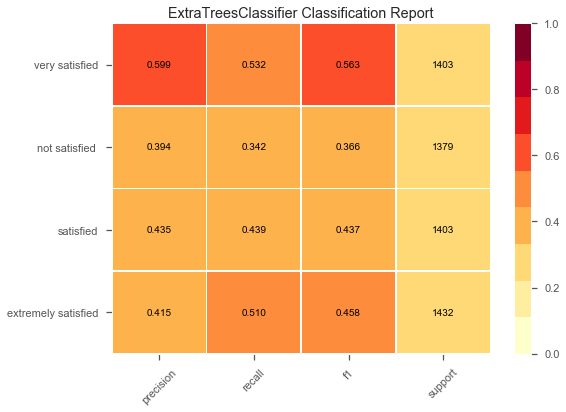

In [293]:
from yellowbrick.classifier import ClassificationReport

# Instantiate the classification model and visualizer
classes=['extremely satisfied','satisfied','not satisfied ','very satisfied']
model = ExtraTreesClassifier()
visualizer = ClassificationReport(model, classes=classes, size=(600, 420), support=True)

visualizer.fit(X_train, y_train.ravel())        # Fit the visualizer and the model
visualizer.score(X_test, y_test.ravel())        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

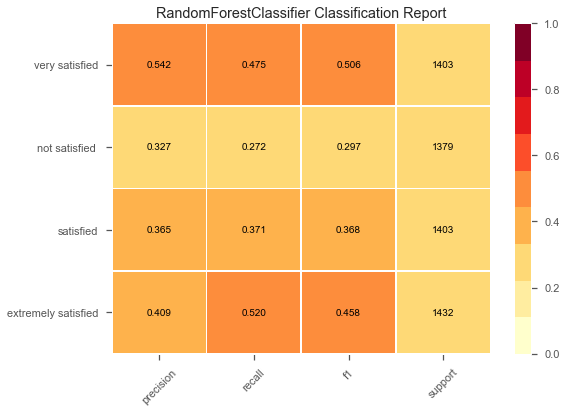

In [294]:

# Instantiate the classification model and visualizer
classes=['extremely satisfied','satisfied','not satisfied ','very satisfied']
model = RandomForestClassifier()
visualizer = ClassificationReport(model, classes=classes, size=(600, 420), support=True)

visualizer.fit(X_train, y_train.ravel())        # Fit the visualizer and the model
visualizer.score(X_test, y_test.ravel())        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

### Confusion Matrixs


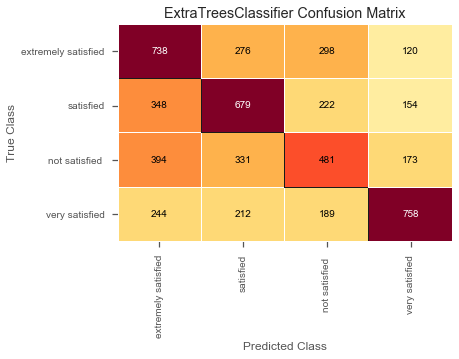

In [295]:
from yellowbrick.classifier import ConfusionMatrix
model = ExtraTreesClassifier()

cm = ConfusionMatrix(model, classes=['extremely satisfied','satisfied','not satisfied ','very satisfied'])

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train, y_train.ravel())

cm.score(X_test, y_test.ravel())

cm.show()

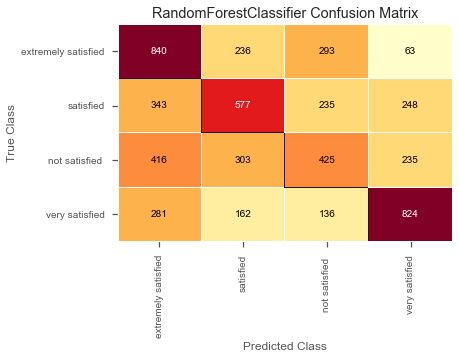

In [296]:
model = RandomForestClassifier(n_estimators=100)

cm = ConfusionMatrix(model, classes=['extremely satisfied','satisfied','not satisfied ','very satisfied'])

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train, y_train.ravel())

cm.score(X_test, y_test.ravel())

cm.show()

### Cross Validation

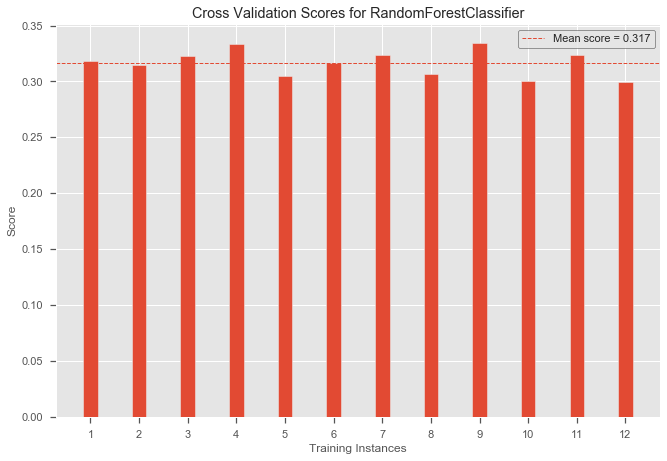

In [297]:
# Without Class balanced
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import CVScores


# Create a cross-validation strategy
cv = StratifiedKFold(n_splits=12, random_state=42)

# Instantiate the classification model and visualizer
model = RandomForestClassifier()
visualizer = CVScores(
    model, cv=cv, scoring='f1_weighted', size=(780, 520)
)

visualizer.fit(X, y)
visualizer.show()

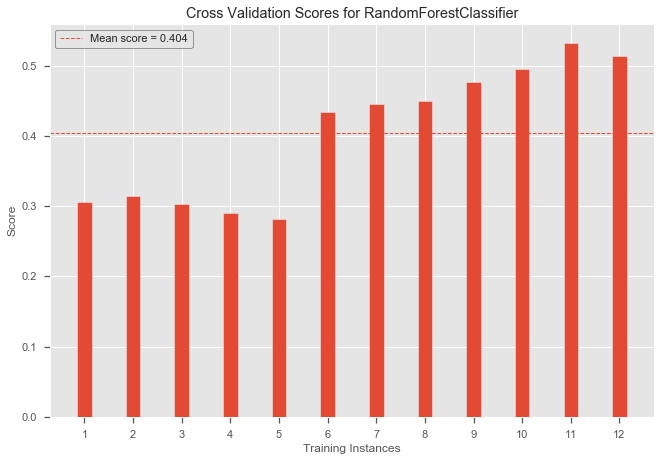

In [298]:
#With Class Balanced

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold

from yellowbrick.model_selection import CVScores


# Create a cross-validation strategy
cv = StratifiedKFold(n_splits=12, random_state=42)

# Instantiate the classification model and visualizer
model = RandomForestClassifier()
visualizer = CVScores(
    model, cv=cv, scoring='f1_weighted', size=(780, 520)
)

visualizer.fit(X_sm, y_sm)
visualizer.show()

### GridSearchCV

In [299]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [304]:

from sklearn.model_selection import GridSearchCV
model = RandomForestClassifier()

# TODO:  Create a dictionary with the Ridge parameter options
parameters = {
    'n_estimators': [200, 300],
    'max_features': ['auto', 'sqrt','log2'],
    'min_samples_split':[2,4,6],
    'n_jobs':[2,4]
}

clf = GridSearchCV(model, parameters, cv=5)
clf.fit(X_train, y_train)

print('If we change our parameters to: {}'.format(clf.best_params_))
print(clf.best_estimator_)

If we change our parameters to: {'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 300, 'n_jobs': 2}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=2,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)


In [302]:
models = [
    RandomForestClassifier(),
    RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, 
                        min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
  
]

for model in models:
    score_model(X_train, y_train.ravel(), model)

RandomForestClassifier: 0.3496528395940894
RandomForestClassifier: 0.42424781912052695
